<a href="https://colab.research.google.com/github/RanjitMane7/stackoverflow-que-tags/blob/main/stackoverflow_que_tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## !pip install tensorflow==1.13.1

In [2]:
tags_list = ['tensorflow', 'keras', 'pandas', 'scikit-learn', 'seaborn', 'numpy', 'matplotlib']

In [3]:
#data_url = r'gdrive://home/bq-results-20210506-000204-wrn723q78ynd/bq-results-20210506-000204-wrn723q78ynd.csv'

In [4]:
#!gsutil cp 'gdrive://home/bq-results-20210506-000204-wrn723q78ynd/bq-results-20210506-000204-wrn723q78ynd.csv' ./

In [5]:
import pandas as pd
import numpy as np

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
df = pd.read_csv("/gdrive/MyDrive/bq-results-20210506-000204-wrn723q78ynd/bq-results-20210506-000204-wrn723q78ynd.csv")

In [8]:
df.head()

,text,tags
0,blabla: scatter and colorbar values i have dat...,"python,matplotlib"
1,code is working but with a 'deprecationwarning...,"python,csv,numpy,statistics,scipy"
2,design strategy for managing and processing da...,"dataset,pandas,pytables"
3,python pattern's restrictingwrapper with metac...,"python,design-patterns,numpy,pandas,metaclass"
4,blabla axes formatting i am creating a realtim...,"python,matplotlib,pyqt"


In [9]:
def req_tags(tags):
    tags_short=[]
    for i in tags_list:
        if i in tags:
            tags_short.append(i)
    return ','.join(tags_short)

In [10]:
df['tags'] = df['tags'].apply(req_tags)

In [11]:
#df['tags'][:5].apply(for t)

In [12]:
# aa = df['tags'][:1]
# aa.apply(req_tags)
# df.head()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411626 entries, 0 to 411625
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    411626 non-null  object
 1   tags    411626 non-null  object
dtypes: object(2)
memory usage: 6.3+ MB


In [14]:
# df['tags'].describe()

In [15]:
# df['tags'].values[:10]

In [16]:
df.shape

(411626, 2)

In [17]:
#imports
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import Sequential

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [18]:
#Shuffling the data
#df = shuffle(df, n_samples=100000, random_state=101)
df = shuffle(df, random_state=101)
# df.shape
# df.head()

In [19]:
df.shape

(411626, 2)

In [20]:
##Encode tags to multi-hot

tags_split = [tags.split(',') for tags in df['tags'].values]
print(len(tags_split), '\n')

411626 



In [21]:
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])

# print(df['text'].values[0])
print(tag_encoder.classes_)
print(tags_encoded[0])

['keras' 'matplotlib' 'numpy' 'pandas' 'scikit-learn' 'seaborn'
 'tensorflow']
[0 0 0 0 1 0 0]


In [22]:
print(tag_encoder.classes_)

['keras' 'matplotlib' 'numpy' 'pandas' 'scikit-learn' 'seaborn'
 'tensorflow']


In [23]:
print(len(tags_encoded))

411626


In [24]:
#train test split
from sklearn.model_selection import train_test_split
train_size = int(len(df) * .8)
print("Train size: %d" % train_size)
print("Test size: %d" % (len(df) - train_size))

Train size: 329300
Test size: 82326


In [25]:
#spliting data between train and test
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

In [26]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
%%writefile preprocess.py

from tensorflow.keras.preprocessing import text

class TextPreprocessor(object):
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None

    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words=self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer

    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix

Overwriting preprocess.py


In [28]:
## Create bag of words matrices

from preprocess import TextPreprocessor

train_qs = df['text'].values[:train_size]
test_qs = df['text'].values[train_size:]

VOCAB_SIZE = 400

processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_qs)

body_train = processor.transform_text(train_qs)
body_test = processor.transform_text(test_qs)

In [29]:
#preview of training data
print(len(body_train[0]))
print(body_train[0])

400
[0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0

In [30]:
# print(df['text'][0])

**Build and Train our Model**

In [63]:
df.shape

(411626, 2)

In [64]:
df.dropna().shape

(411626, 2)

In [31]:
#Save the tokenizer state

import pickle

with open('./processor_state.pkl', 'wb') as f:
    pickle.dump(processor, f)

In [32]:
num_tags

7

In [33]:
## Create the model

def create_model(vocab_size, num_tags):
    model = Sequential()
    model.add(Dense(50, input_shape=(vocab_size,), activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(50, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(num_tags, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

model = create_model(VOCAB_SIZE, num_tags)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                20050     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 182       
Total params: 21,507
Trainable params: 21,507
Non-trainable params: 0
_________________________________________________________________


In [34]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [35]:
## Train
model.fit(body_train, train_tags, epochs=3, batch_size=128, validation_split=0.1, verbose=1, callbacks=[early_stop])

Train on 296370 samples, validate on 32930 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
296370/296370 [==============================] - 7s 25us/sample - loss: 0.1385 - acc: 0.9482 - val_loss: 0.1178 - val_acc: 0.9554
Epoch 2/3
296370/296370 [==============================] - 7s 24us/sample - loss: 0.1127 - acc: 0.9573 - val_loss: 0.1135 - val_acc: 0.9567
Epoch 3/3
296370/296370 [==============================] - 7s 24us/sample - loss: 0.1089 - acc: 0.9584 - val_loss: 0.1118 - val_acc: 0.9572


In [36]:
losses = pd.DataFrame(model.history.history)

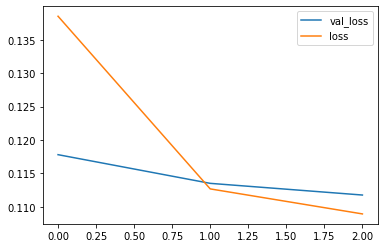

In [37]:
losses[['val_loss', 'loss']].plot()

In [38]:
## Evalute
model.evaluate(body_test, test_tags, batch_size=128)

## Epochs = 3
# 644/644 [==============================] - 1s 1ms/step - loss: 0.1101 - accuracy: 0.8389
# [0.11007880419492722, 0.8388601541519165]

##Epochs = 25
# 644/644 [==============================] - 1s 1ms/step - loss: 0.1136 - accuracy: 0.8345
# [0.1136125847697258, 0.8345237374305725]

##Model shape 50>25>out
# 644/644 [==============================] - 1s 1ms/step - loss: 0.1116 - accuracy: 0.8378
# [0.11160676926374435, 0.8377547860145569]

## Model Shape is changed to 100 > 50 > 25 > out ---- Overfitting
# 644/644 [==============================] - 1s 1ms/step - loss: 0.1246 - accuracy: 0.8327
# [0.12457164376974106, 0.8326895236968994]

## Dropout 0.2 with 100 > 50>25
# 644/644 [==============================] - 1s 1ms/step - loss: 0.1135 - accuracy: 0.8352
# [0.11345642060041428, 0.8352282643318176]

## Dropout 0.2 with 50 > 25 >.
# 644/644 [==============================] - 1s 1ms/step - loss: 0.1100 - accuracy: 0.8391
# [0.11001169681549072, 0.839103102684021]

82326/82326 [==============================] - 1s 12us/sample - loss: 0.1096 - acc: 0.9583


[0.10963479367743671, 0.95831585]

In [39]:
model.save('keras_stackoverflow_tags.h5')

In [40]:
%%writefile model_prediction.py
import pickle
import os
import numpy as np

class CustomModelPrediction(object):

    def __init__(self, model, processor):
        self._model = model
        self._processor = processor

    def predict(self, instances, **kwargs):
        preprocessed_data = self._processor.transform_text(instances)
        predictions = self._model.predict(preprocessed_data)
        return predictions.tolist()

    @classmethod
    def from_path(cls, model_dir):
        import tensorflow.keras as keras
        model = keras.models.load_model(
            os.path.join(model_dir,'keras_stackoverflow_tags.h5')
        )
        with open(os.path.join(model_dir, 'processor_state.pkl'), 'rb') as f:
            processor = pickle.load(f)

        return cls(model, processor)

Overwriting model_prediction.py


In [41]:
# for i in range(len(test_set)):
#     print('Predicted Labels:')
#     for idx, val in enumerate(results[i]):
#         if val > 0.7:
#             print(tag_encoder.classes_[idx])
#     print('\n')

In [50]:
que5 = '''

I have a classification (Keras) with LSTM for a dataset with 4 attributes labeled into 2 classes (safe and unsafe). with put the sigmoid in the last layer I got a better accuracy of 98% rather than softmax. My question is that:
1 )If I use Softmax in the last layer: in Softmax based on the 2 neurons as output at the end in other code, I can compare the score and say the data belong to which. For example score_safe= 1.2945 and score_unsafe= -9.0 then I can say this row of dataset belongs to the safe class. 2)If I use Sigmid in the last layer: Then I had to put just a neuron as up output and how can I compare the scores and how can say this row of datasets belongs to which class?

model = Sequential()
model.add(LSTM(256, input_shape=(x_train.shape[1:]), activation='tanh', return_sequences=True))
#model.add(BatchNormalization())
model.add(Dense(128, activation='tanh'))
#model.add(BatchNormalization())
model.add(Dense(128, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))'''

test_set = [
  "How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error: You must feed a value for placeholder tensor 'input_1' with dtype string and shape [?, 1] def text_preprocess(x): strings = tf.keras.backend.eval(x) vectors = [] for string in strings: vector = string_to_one_hot(string.decode('utf-8')) vectors.append(vector) vectorTensor = tf.constant(np.array(vectors),dtype=tf.float32) return vectorTensor input_text = Input(shape=(1,), dtype=tf.string) embedding = Lambda(text_preprocess)(input_text) dense = Dense(256, activation='relu')(embedding) outputs = Dense(2, activation='softmax')(dense) model = Model(inputs=[input_text], outputs=outputs) model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) model.summary() model.save('test.h5') If I pass a string array into the input layer statically, I can compile the model, but I get the same error if I want to convert the model to tflite. #I replaced this line: input_text = Input(shape=(1,), dtype=tf.string) #by this lines: test = tf.constant(['Hello', 'World']) input_text = Input(shape=(1,), dtype=tf.string, tensor=test) #but calling this ... converter = TFLiteConverter.from_keras_model_file('string_test.h5') tfmodel = converter.convert() #... still leads to this error: InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype string and shape [2] [[{{node input_3}}]] ",
  "Change the bar item name in Pandas I have a test excel file like: df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]}) print (df) name  age 0    a   10 1    b   20 2    c    5 3    d   23 4    e   58 5    f    4 6    g    6 I use Pandas and matplotlib to read and plot it: import pandas as pd import numpy as np import matplotlib.pyplot as plt import os excel_file = 'test.xlsx' df = pd.read_excel(excel_file, sheet_name=0) df.plot(kind='bar') plt.show() the result shows: enter image description here it use index number as item name, how can I change it to the name, which stored in column name?"
]

In [52]:
# test_set = ["keras NN 60% accuracy during training 0.0% accuracy during test I've done this nn with keras that have a 60% accuracy during training. The problem is when i try to test my network with a dataset i get a network that is super sure that all the images are in the"]
# test_set = ["Sigmoid as a last layer in LSTM I have a classification (Keras) with LSTM for a dataset with 4 attributes labeled into 2 classes (safe and unsafe). with put the sigmoid in the last layer I got a better accuracy of 98% rather than "]
# test_set = [que5]

from model_prediction import CustomModelPrediction

classifier = CustomModelPrediction.from_path('.')
results = classifier.predict(test_set)
print(','.join(tag_encoder.classes_))
for i in results:print(i)

for i in range(len(test_set)):
    print('Predicted Labels:')
    for idx, val in enumerate(results[i]):
        if val > 0.6:
            print(tag_encoder.classes_[idx], val)
    print('\n')

keras,matplotlib,numpy,pandas,scikit-learn,seaborn,tensorflow
[0.7152091264724731, 8.642673492431641e-07, 0.052270472049713135, 0.0003718733787536621, 8.14199447631836e-05, 1.7881393432617188e-07, 0.9483177661895752]
[5.453824996948242e-06, 0.6617723107337952, 0.15700669586658478, 0.6872650384902954, 0.0009212971199303865, 0.013046854175627232, 3.6413746329344576e-06]
Predicted Labels:
keras 0.7152091264724731
tensorflow 0.9483177661895752


Predicted Labels:
matplotlib 0.6617723107337952
pandas 0.6872650384902954




In [44]:
#classification report and confusion matrix
from sklearn.metrics import classification_report

predictions = model.predict(body_test) #test_tags

In [45]:
pred_df = pd.DataFrame(predictions)

In [46]:
pred_df = pred_df.apply(lambda i : i > 0.7)

In [47]:
print(classification_report(test_tags, pred_df))

              precision    recall  f1-score   support

           0       0.88      0.59      0.70      7085
           1       0.91      0.77      0.83     11476
           2       0.95      0.63      0.75     17441
           3       0.98      0.89      0.93     38650
           4       0.91      0.67      0.77      4495
           5       0.94      0.10      0.18      1280
           6       0.93      0.74      0.82     14147

   micro avg       0.95      0.76      0.84     94574
   macro avg       0.93      0.63      0.71     94574
weighted avg       0.95      0.76      0.84     94574
 samples avg       0.86      0.81      0.82     94574



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**pkg and deploy**

In [53]:
%%writefile setup.py

from setuptools import setup

setup(
    name="so_predict",
    version="0.1",
    include_package_date=True,
    scripts=['perprocess.py', 'model_prediction.py']
)

Overwriting setup.py


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [54]:
!gsutil cp keras_stackoverflow_tags.h5 gs://stackoverflow-que-tags-aibuck/
!gsutil cp processor_state.pkl gs://stackoverflow-que-tags-aibuck/

Copying file://keras_stackoverflow_tags.h5 [Content-Type=application/octet-stream]...
/ [1 files][278.2 KiB/278.2 KiB]                                                
Operation completed over 1 objects/278.2 KiB.                                    
Copying file://processor_state.pkl [Content-Type=application/octet-stream]...
- [1 files][ 63.4 MiB/ 63.4 MiB]                                                
Operation completed over 1 objects/63.4 MiB.                                     


In [55]:
!python setup.py sdist

/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'include_package_date'
  warnings.warn(msg)
running sdist
running egg_info
writing so_predict.egg-info/PKG-INFO
writing dependency_links to so_predict.egg-info/dependency_links.txt
writing top-level names to so_predict.egg-info/top_level.txt
reading manifest file 'so_predict.egg-info/SOURCES.txt'
writing manifest file 'so_predict.egg-info/SOURCES.txt'

running check


creating so_predict-0.1
creating so_predict-0.1/so_predict.egg-info
copying files to so_predict-0.1...
copying model_prediction.py -> so_predict-0.1
copying setup.py -> so_predict-0.1
copying so_predict.egg-info/PKG-INFO -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/SOURCES.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/dependency_links.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/top_level.txt -> so_predict-0.1/so_predict.egg-info
Writing so_predict-0.1/setup.cfg
Creating

In [56]:
!gsutil cp ./dist/so_predict-0.1.tar.gz gs://stackoverflow-que-tags-aibuck/packages/so_predict-0.1.tar.gz

Copying file://./dist/so_predict-0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  987.0 B/  987.0 B]                                                
Operation completed over 1 objects/987.0 B.                                      


In [57]:
 ## Set gcloud to demo project
 !gcloud config set project stackoverflow-que-tags

Updated property [core/project].


In [ ]:
## Deploy model to AI Platform with custom code

In [58]:
%%writefile config.yaml
autoScaling:
    minNodes: 1

Overwriting config.yaml


In [ ]:
!python --version
tensorflow
--runtime-version=1.13 \
--framework='TENSORFLOW' \

In [ ]:
!gcloud config set ai_platform/region global

In [76]:
!gcloud beta ai-platform versions create v13 --model stacko_model \
--origin=gs://stackoverflow-que-tags-aibuck/ \
--python-version=3.5 \
--runtime-version=1.13 \
--framework='TENSORFLOW' \
--config=config.yaml \
--package-uris=gs://stackoverflow-que-tags-aibuck/packages/so_predict-0.1.tar.gz \
--prediction-class=model_prediction.CustomModelPrediction

Using endpoint [https://ml.googleapis.com/]
ERROR: (gcloud.beta.ai-platform.versions.create) FAILED_PRECONDITION: Field: prediction_class Error: Exactly one of "prediction_class" and "framework" may be provided. In order to use a custom prediction class, "framework" should be left unspecified.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: Exactly one of "prediction_class" and "framework" may be provided.
      In order to use a custom prediction class, "framework" should be left unspecified.
    field: prediction_class


**Interpreting out Model with SHAP**

In [68]:
!pip install shap

     |████████████████████████████████| 358kB 7.6MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491625 sha256=bd1c9aa900cc9cfc6d3e7d19df53a0cb4e24ce6ce0b803b36080366393c880e2
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [69]:
import shap
attrib_data = body_train[:200]
explainer = shap.DeepExplainer(model, attrib_data)

num_explanations = 25
shap_vals = explainer.shap_values(body_test[:num_explanations])

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [70]:
words = processor._tokenizer.word_index

In [71]:
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
print(word_lookup[:100])

['', '0', 'the', 'i', '1', 'to', 'a', 'in', 'blabla', '2', 'and', 'of', 'is', '3', 'for', 'x', 'data', 'this', 'df', 'with', 'as', 'quot', '5', 'gt', '4', 'np', 'it', 'from', 'import', 'that', 'have', 'model', 'y', 'tf', "'", 'but', 'self', 'dataframe', 'file', 'my', '00', '10', 'if', 'how', 'on', 'not', 'python', '6', 'array', '7', 'lt', 'get', 'be', 'train', '01', 'like', 'c', 'using', 'code', 'am', 'column', 'values', 'pd', 'nan', 'line', 'input', 'can', 'py', 'name', 'index', 'plt', 'print', 'size', 'value', 'shape', 'b', '8', 'do', 'so', 'columns', 'want', 'an', 'error', 'are', 'test', 'output', 'true', 'n', 'return', 'lib', 'list', 'plot', 'set', '12', 'time', '9', 'or', 'use', 'def', 'all']


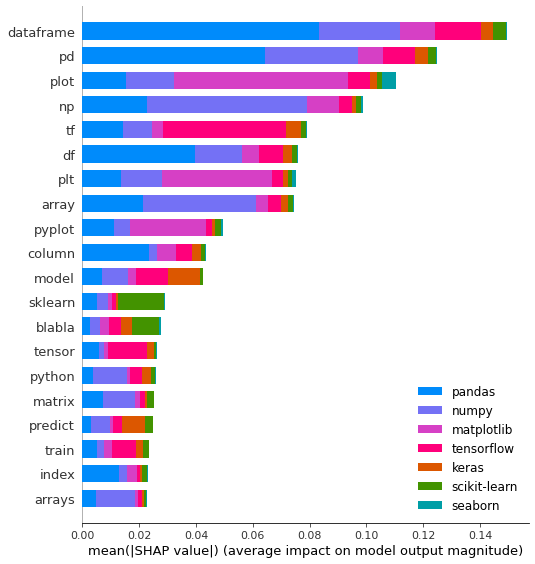

In [72]:
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)